## Machine Learning Chapter 6

### 1. What is the approximate depth of a Decision Tree trained (without restrictions) on a training set with one million instances?
> Kedalaman pohon biner yang seimbang dengan m daun sekitar log2(m), dibulatkan ke atas. Pada pohon keputusan dengan 1 juta data latih, kedalamannya sekitar 20.

### 2. Is a node’s Gini impurity generally lower or greater than its parent’s? Is it generally lower/greater, or always lower/greater?
> Impuritas Gini pada node biasanya lebih rendah daripada induknya, namun bisa lebih tinggi jika penurunan impuritas pada anak lainnya lebih besar. Algoritma Decision Tree mampu meminimalkan jumlah bobot impuritas Gini pada anak-anaknya.

###  3. If a Decision Tree is overfitting the training set, is it a good idea to try decreasing max_depth?
> Jika pohon keputusan mengalami overfitting, mengurangi max_depth dapat membantu mereduksi kompleksitas model dan mencegah overfitting. Sehingga, keputusan untuk mengurangi max_depth adalah hal yang tepat untuk menghindari overfitting.

###  4. If a Decision Tree is underfitting the training set, is it a good idea to try scaling the input features?
> Decision Tree tidak memerlukan penskalaan atau pemusatan data. Jika model underfitting, penskalaan fitur tidak akan memperbaiki performanya.

###  5. If it takes one hour to train a Decision Tree on a training set containing 1 million instances, roughly how much time will it take to train another Decision Tree on a training set containing 10 million instances?
> Kompleksitas pelatihan pohon keputusan adalah O(n × m log(m)). Jika ukuran data dilipatgandakan, waktu pelatihan akan meningkat sekitar 11,7 kali untuk 1 juta data.

###  6. If your training set contains 100,000 instances, will setting presort=True speed up training?
> Menyusun data sebelumnya mempercepat pelatihan hanya pada dataset kecil, namun akan memperlambat pelatihan jika datasetnya besar. Sehingga, untuk kasus dataset sebesari 100.000, akan memperlambat proses pelatihannya.


### 7. Train and fine-tune a Decision Tree for the moons dataset by following these steps:

#### a. Use make_moons(n_samples=10000, noise=0.4) to generate a moons dataset.

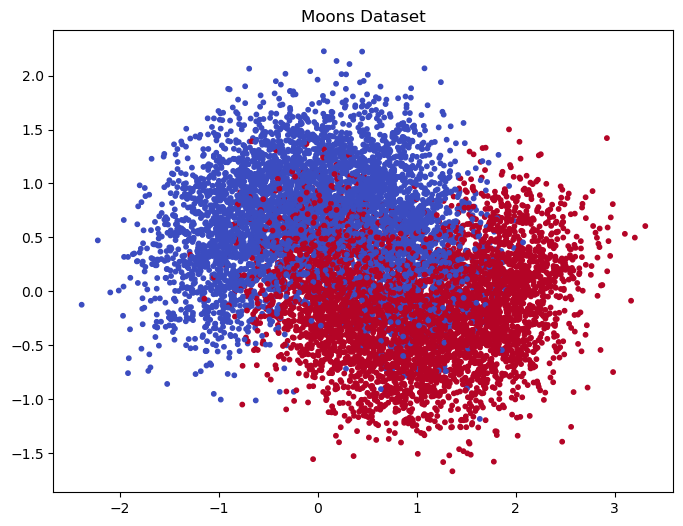

In [1]:
from sklearn.datasets import make_moons
import numpy as np
import matplotlib.pyplot as plt

X, y = make_moons(n_samples=10000, noise=0.4, random_state=42)

# Visualize the dataset
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=10)
plt.title("Moons Dataset")
plt.show()

#### b. Use train_test_split() to split the dataset into a training set and a test set.

In [2]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### c. Use grid search with cross-validation (with the help of the GridSearchCVclass) to find good hyperparameter values for a DecisionTreeClassifier. Hint: try various values for max_leaf_nodes.

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

dt = DecisionTreeClassifier(random_state=42)

param_grid = {
    'max_leaf_nodes': [10, 20, 30, 40, 50, 100, 200]
}

grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')

grid_search.fit(X_train, y_train)

print("Best Hyperparameters:", grid_search.best_params_)

Best Hyperparameters: {'max_leaf_nodes': 20}


#### d. Train it on the full training set using these hyperparameters, and measure your model’s performance on the test set. You should get roughly 85% to 87% accuracy.

In [4]:
# Retrieve the best model from grid search
best_dt = grid_search.best_estimator_

# Train the model on the full training set
best_dt.fit(X_train, y_train)

# Evaluate the model's performance on the test set
test_accuracy = best_dt.score(X_test, y_test)

print(f"Test Set Accuracy: {test_accuracy * 100:.2f}%")

Test Set Accuracy: 87.00%


### 8. Grow a forest by following these steps:

#### a. Continuing the previous exercise, generate 1,000 subsets of the training set, each containing 100 instances selected randomly. Hint: you can use ScikitLearn’s ShuffleSplit class for this.

In [5]:
import numpy as np
from sklearn.model_selection import ShuffleSplit

ss = ShuffleSplit(
    n_splits=1000,
    train_size=100,
    random_state=42
)

subset_indices = []

for train_idx, _ in ss.split(X_train):
    subset_indices.append(train_idx)

print("Jumlah subset:", len(subset_indices))
print("Ukuran subset pertama:", len(subset_indices[0]))

Jumlah subset: 1000
Ukuran subset pertama: 100


#### b. Train one Decision Tree on each subset, using the best hyperparameter values found in the previous exercise. Evaluate these 1,000 Decision Trees on the test set. Since they were trained on smaller sets, these Decision Trees will likely perform worse than the first Decision Tree, achieving only about 80% accuracy.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

trees = []
accuracies = []

best_params = grid_search.best_params_
print("Best params dari latihan sebelumnya:", best_params)

for idx, train_idx in enumerate(subset_indices):
    X_sub = X_train[train_idx]
    y_sub = y_train[train_idx]
    
    tree = DecisionTreeClassifier(
        **best_params,
        random_state=idx
    )
    
    tree.fit(X_sub, y_sub)
    trees.append(tree)
    
    y_pred_test = tree.predict(X_test)
    acc = accuracy_score(y_test, y_pred_test)
    accuracies.append(acc)

print(f"Rata-rata akurasi 1000 Decision Tree (subset 100 data): {np.mean(accuracies)*100:.2f}%")
print(f"Standar deviasi akurasi: {np.std(accuracies)*100:.2f}%")

Best params dari latihan sebelumnya: {'max_leaf_nodes': 20}
Rata-rata akurasi 1000 Decision Tree (subset 100 data): 80.09%
Standar deviasi akurasi: 2.49%


#### c. Now comes the magic. For each test set instance, generate the predictions of the 1,000 Decision Trees, and keep only the most frequent prediction (you can use SciPy’s mode() function for this). This approach gives you majority-vote predictions over the test set.

In [7]:
import numpy as np
from scipy.stats import mode

all_predictions = np.array([
    tree.predict(X_test) for tree in trees
])

print("Shape all_predictions:", all_predictions.shape)

y_pred_ensemble, _ = mode(all_predictions, axis=0, keepdims=False)

print("Shape y_pred_ensemble:", y_pred_ensemble.shape)

Shape all_predictions: (1000, 2000)
Shape y_pred_ensemble: (2000,)


#### d. Evaluate these predictions on the test set: you should obtain a slightly higher accuracy than your first model (about 0.5 to 1.5% higher).

In [8]:
from sklearn.metrics import accuracy_score

ensemble_accuracy = accuracy_score(y_test, y_pred_ensemble)

print(f"Akurasi single best Decision Tree (dari latihan sebelumnya): {grid_search.best_estimator_.score(X_test, y_test)*100:.2f}%")
print(f"Akurasi majority-vote 1000 Decision Tree: {ensemble_accuracy*100:.2f}%")


Akurasi single best Decision Tree (dari latihan sebelumnya): 87.00%
Akurasi majority-vote 1000 Decision Tree: 87.20%
